In [3]:
%run ../Python/PageHD1.py
%matplotlib notebook

import toml

import time, subprocess, uuid, os, shutil
from threading import Thread, current_thread

import sys
sys.path.append('HORD/pySOT/')
sys.path.append('HORD/pySOT/src')
from src import SyncStrategyNoConstraints, LatinHypercube, RBFInterpolant, CubicRBFSurface, CandidateDYCORS
from poap.controller import ThreadController, BasicWorkerThread, SerialController

#import logging
#logger = sot_sync_strategies.logger
#logger.setLevel(logging.DEBUG)


#rate_buf_ival = 2**-6
#N_PLACE = 200
#N_PLACExFVxHD = 600
expt = "PLACE_proximal-only3"
#expt_path = "/home/toby/src/oftnai/Spike-experiments/Build/Examples/" + expt
#cwd = "/home/toby/src/oftnai/Spike-experiments/Build/pandapics"
#outdir = cwd + "/" + expt

In [2]:
toml_file = "/home/toby/src/oftnai/Spike-experiments/Examples/toml/" + expt + ".toml"
params = toml.load(open(toml_file))
params

{'FV_PLACExFVxHD_scaling': 3.5625,
 'HD_PLACExFVxHD_scaling': 8.375,
 'PLACE_PLACExFVxHD_scaling': 30.4166666666,
 'PLACE_inhibition': 0.0,
 'PLACExFVxHD_PLACE_scaling': 0.0,
 'PLACExFVxHD_inhibition': -0.6041666666,
 'VIS_PLACE_INH_scaling': -0.00225,
 'VIS_PLACE_scaling': 1.35,
 'eps': 0.08,
 'output_path': '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/PLACE_proximal-only3',
 'pause_duration': 10.0,
 'pause_time': 1650.0,
 'test_off_time': 160.0,
 'test_on_time': 155.0,
 'train_time': 1500.0}

In [ ]:
from contextlib import contextmanager
import pickle

class Problem:
    expt = expt
    cwd = "/home/toby/src/oftnai/Spike-experiments/Build/pandapics"
    build_dir = "/home/toby/src/oftnai/Spike-experiments/Build/Examples"
    toml_dir = "/home/toby/src/oftnai/Spike-experiments/Examples/toml"
    
    N_PLACE = 400
    N_PLACExFVxHD = 800

    rate_buf_ival = 2**-6

    target_Rmax = 95
    target_sparsity_PLACE = 3.5
    target_sparsity_PLACExFVxHD = 1.5

    delta = 0.5 # weight to give to difference between PLACE and PLACExFVxHD encodings
    rho = 10 # weight to give to sparsity loss
    sigma = 36 # weight to give to sparsity std.dev
    omega = 0.6 * 1e-2 # weight for power spec

    eps = 0.06

    train_time = 1500
    test_on_time = 190
    test_off_time = 30

    pause_time = 1650
    pause_duration = 40
    
    loss_window_start = 1500
    loss_window_size = 200
    loss_window_pane_size = 5
    
    loss_window_starts = []
    loss_windows = []
    
    num_evals = 0
    trials = []

    # VIS_PLACE_scaling, VIS_PLACE_INH_scaling,
    #   PLACExFVxHD_PLACE_scaling [3, 9], PLACE_inhibition [-1.2, -0.1],
    #   PLACE_PLACExFVxHD_scaling, PLACExFVxHD_inhibition
    #   FV_PLACExFVxHD_scaling, HD_PLACExFVxHD_scaling
    xlow = np.array([3.0, -2.4, 15.0, -2.40, 2.5,  7.0])  # lower bounds
    xup = np.array([ 9.0, -0.1, 80.0, -0.60, 6.0, 14.0])  # upper bounds
    dim = xlow.size
    continuous = range(dim)
    integer = []

    keep_top = 10
    print_top = 10
    deleted = []

    def __init__(self):
        self.outdir = self.cwd + "/HORD/" + self.expt
        self.expt_path = self.build_dir + '/' + self.expt
        self.orig_toml_file = self.toml_dir + '/' + self.expt + ".toml"
        
        str_time = str(int(time.time()))
        self.log_file = self.cwd + "/HORD_" + str_time + ".log"
        self.trials_file = self.cwd + "/HORD_" + str_time + "_trials.pickle"
        self.lock_file = self.cwd + "/HORD_" + str_time + ".lock"
        
        # TODO: Overlapping panes
        num_panes = self.loss_window_size // self.loss_window_pane_size
        t = self.loss_window_start
        for i in range(num_panes):
            self.loss_window_starts.append(t)
            t += self.loss_window_pane_size
        
        for s in self.loss_window_starts:
            start_t = s
            stop_t = start_t + self.loss_window_pane_size
            start_i = int(start_t/self.rate_buf_ival)
            stop_i = int(stop_t/self.rate_buf_ival)
            self.loss_windows.append((start_i, stop_i, 1.0/len(self.loss_window_starts)))
        
        self.min_start_i = int(self.loss_window_start/self.rate_buf_ival)
        self.max_stop_i = int((self.loss_window_start+self.loss_window_size)/self.rate_buf_ival)
        self.loss_windows.append((self.min_start_i, self.max_stop_i, 1.0))
        
        print(self.log_file)

        print(self.loss_windows)
        with open(self.log_file, 'a') as log:
            print(self.loss_windows, file=log)

    @contextmanager
    def obtain_lock(self):
        while os.path.exists(self.lock_file):
            time.sleep(0.2)
        with open(self.lock_file, 'w') as lock:
            yield
        os.remove(self.lock_file)

    def objfunction(self, new_params):
        # Use temporary output dir
        outdir = self.outdir + '.' + str(int(time.time()*100)) + '.' + str(current_thread().ident) 
        os.makedirs(outdir)
        new_toml_file = outdir + '/' + self.expt + ".toml"

        # Save params to toml file:
        params = toml.load(open(self.orig_toml_file))
        params['output_path'] = outdir
        
        params['eps'] = float(self.eps)
        params['train_time'] = float(self.train_time)
        params['test_on_time'] = float(self.test_on_time)
        params['test_off_time'] = float(self.test_off_time)
        
        params['pause_time'] = float(self.pause_time)
        params['pause_duration'] = float(self.pause_duration)

        p_i = 0
        params['VIS_PLACE_scaling'] = 1.35 # 1.3454234471763724 # float(new_params[p_i]); p_i += 1
        params['VIS_PLACE_INH_scaling'] = -0.005066 # float(new_params[p_i]); p_i += 1
        params['PLACExFVxHD_PLACE_scaling'] = float(new_params[p_i]); p_i += 1
        params['PLACE_inhibition'] = float(new_params[p_i]); p_i += 1
        params['PLACE_PLACExFVxHD_scaling'] = float(new_params[p_i]); p_i += 1
        params['PLACExFVxHD_inhibition'] = float(new_params[p_i]); p_i += 1
        params['FV_PLACExFVxHD_scaling'] = float(new_params[p_i]); p_i += 1
        params['HD_PLACExFVxHD_scaling'] = float(new_params[p_i]); p_i += 1
        toml.dump(params, open(new_toml_file, 'w'))

        while True:
            result = None
            try:
                subprocess.run(["find", outdir] + "-name simulation.lock -exec rm {} +".split(' '))
                result = subprocess.run([self.expt_path, new_toml_file],
                                        cwd=self.cwd, stdout=subprocess.PIPE,
                                        stderr=subprocess.PIPE, check=True)
                break
            except subprocess.CalledProcessError as e:
                # Hackily deal with weird VIS bug:
                if 127 == e.returncode:
                    params['test_off_time'] = float(params['test_off_time'] + 0.1)
                    toml.dump(params, open(new_toml_file, 'w'))
                else:
                    print(e)
                    print(e.stdout)
                    print(e.stderr)
                    raise

        # Compute loss:
        sparsities_PLACE = []
        sparsities_PLACExFVxHD = []

        R_PLACE = read_rates(outdir, 'PLACE', self.N_PLACE)[:, self.min_start_i:self.max_stop_i]
        R_PLACExFVxHD = read_rates(outdir, 'PLACExFVxHD', self.N_PLACExFVxHD)[:, self.min_start_i:self.max_stop_i]
        H_PLACExFVxHD_PLACE = accumulate_activation(outdir, 'PLACE', ['PLACExFVxHD'], self.N_PLACE,
                                                    slice(self.min_start_i, self.max_stop_i))
        H_cmb_scale = H_PLACExFVxHD_PLACE - np.min(H_PLACExFVxHD_PLACE)
        H_cmb_scale /= np.max(H_cmb_scale)
        
        loss = 0
        for w in self.loss_windows:
            start_i, stop_i, weight = w
            start_i -= self.min_start_i
            stop_i -= self.min_start_i
            
            sparsity_PLACE = np.mean(R_PLACE[:, start_i:stop_i]) * 100
            Rmax_PLACE = np.max(R_PLACE[:, start_i:stop_i]) * 100
            sparsities_PLACE.append(sparsity_PLACE)
            
            sparsity_PLACExFVxHD = np.mean(R_PLACExFVxHD[:, start_i:stop_i]) * 100
            Rmax_PLACExFVxHD = np.max(R_PLACExFVxHD[:, start_i:stop_i]) * 100
            sparsities_PLACExFVxHD.append(sparsity_PLACExFVxHD)

            l =  weight * ((self.target_Rmax-Rmax_PLACE)**2 + (self.rho*(self.target_sparsity_PLACE-sparsity_PLACE))**2)
            l += weight * ((self.target_Rmax-Rmax_PLACExFVxHD)**2 + (self.rho*(self.target_sparsity_PLACExFVxHD-sparsity_PLACExFVxHD))**2)
            
            l_delta = np.mean(((R_PLACE[:, start_i:stop_i]-H_cmb_scale[:, start_i:stop_i])/R_PLACE[:, start_i:stop_i])**2)
            l += weight * l_delta
            
            power = np.mean(np.abs(np.fft.fft(R_PLACE, axis=1))**2, axis=0)
            f = int(1.0/self.rate_buf_ival)
            power = power[f:len(power)//2]
            l_power = self.omega * np.sum(power)
            if np.isfinite(l_power):
                l += weight * l_power
            else:
                l += np.inf

            #print(w, l, sparsity_PLACE, Rmax_PLACE)
            loss += l

        if np.mean(sparsities_PLACE) > 1e-4:
            loss += (self.sigma * np.std(sparsities_PLACE)/np.mean(sparsities_PLACE))**2
        if np.mean(sparsities_PLACExFVxHD) > 1e-4:
            loss += (self.sigma * np.std(sparsities_PLACExFVxHD)/np.mean(sparsities_PLACExFVxHD))**2
            
        with self.obtain_lock():
            # Print & store diagnostics:
            self.num_evals += 1
            to_print = "\n*** {} @ {} \n{}, {}\nPLACE: ({}, {})\nPLACExFVxHD: ({}, {})\n{}\n".format(
                self.num_evals, outdir,
                loss, time.time(),
                np.mean(sparsities_PLACE), np.std(sparsities_PLACE),
                np.mean(sparsities_PLACExFVxHD), np.std(sparsities_PLACExFVxHD),
                repr(np.array(new_params).tolist()))
            self.trials.append((loss,
                                (np.mean(sparsities_PLACE), np.std(sparsities_PLACE)),
                                (np.mean(sparsities_PLACExFVxHD), np.std(sparsities_PLACExFVxHD)),
                                np.array(new_params).tolist(),
                                outdir))
            self.trials = sorted([x for x in self.trials if not np.isinf(x[0])], key=lambda x: x[0])
            if self.num_evals > self.print_top:
                for _ in range(self.print_top): to_print += "\n" + "{}".format(repr(self.trials[_]))
            to_print += '\n'
            print(to_print)
            
            with open(self.log_file, 'a') as log:
                print(to_print, file=log)
            
            with open(self.trials_file, 'wb') as f:
                pickle.dump(self.trials, f)

            # Clean up output dirs
            if len(self.trials) > self.keep_top:
                for trl in self.trials[self.keep_top:]:
                    shutil.rmtree(trl[4], True)
                    self.deleted.append(trl[4])

        # Done
        return loss


nthreads = 5
maxeval = 200
nsamples = nthreads

data = Problem()

controller = None
if nthreads > 1:
    controller = ThreadController()
else:
    controller = SerialController(data.objfunction)

controller.strategy = \
    SyncStrategyNoConstraints(
    worker_id=0, data=data,
    maxeval=maxeval, nsamples=nsamples,
    exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
    response_surface=RBFInterpolant(surftype=CubicRBFSurface, maxp=maxeval),
    sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
if nthreads > 1:
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)

# Run the optimization strategy
start_time = time.time()
result = controller.run()
print("Time taken: {}\n".format(time.time()-start_time))

print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}\n'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                 precision=5, suppress_small=True)))

/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD_1528732271.log
[(96000, 96320, 0.025), (96320, 96640, 0.025), (96640, 96960, 0.025), (96960, 97280, 0.025), (97280, 97600, 0.025), (97600, 97920, 0.025), (97920, 98240, 0.025), (98240, 98560, 0.025), (98560, 98880, 0.025), (98880, 99200, 0.025), (99200, 99520, 0.025), (99520, 99840, 0.025), (99840, 100160, 0.025), (100160, 100480, 0.025), (100480, 100800, 0.025), (100800, 101120, 0.025), (101120, 101440, 0.025), (101440, 101760, 0.025), (101760, 102080, 0.025), (102080, 102400, 0.025), (102400, 102720, 0.025), (102720, 103040, 0.025), (103040, 103360, 0.025), (103360, 103680, 0.025), (103680, 104000, 0.025), (104000, 104320, 0.025), (104320, 104640, 0.025), (104640, 104960, 0.025), (104960, 105280, 0.025), (105280, 105600, 0.025), (105600, 105920, 0.025), (105920, 106240, 0.025), (106240, 106560, 0.025), (106560, 106880, 0.025), (106880, 107200, 0.025), (107200, 107520, 0.025), (107520, 107840, 0.025), (107840, 108160, 0.025)


*** 13 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152874778794.139974996145920 
21311.724302141673, 1528753949.5658383
PLACE: (6.061926929325592, 0.09561534070181535)
PLACExFVxHD: (6.16382863826868, 0.07510107395069186)
[8.357142857142858, -1.332142857142857, 59.107142857142854, -2.0785714285714287, 4.875, 10.25]

(14298.345022040714, (3.861913741452665, 1.2932415050325838), (5.218406530415139, 1.0174417962708195), [7.928571428571429, -2.3178571428571426, 26.607142857142854, -0.7928571428571431, 4.125, 11.75], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152873996588.139974987753216')
(15404.203009450663, (5.146030618286714, 1.6110739332732649), (6.718826121309909, 1.743145108805), [3.642857142857143, -0.8392857142857144, 31.25, -1.05, 5.875, 9.25], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152873227221.139974970967808')
(21311.724302141673, (6.061926929325592, 0.095


*** 16 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152875400168.139974996145920 
15950.902240152673, 1528761560.155703
PLACE: (5.817393522437026, 0.6859104673379511)
PLACExFVxHD: (6.674397618668835, 0.6262764990101927)
[8.166751958415334, -2.1447801121808157, 26.43899294545761, -0.8750675653604251, 5.671218172226658, 13.598349053025956]

(14298.345022040714, (3.861913741452665, 1.2932415050325838), (5.218406530415139, 1.0174417962708195), [7.928571428571429, -2.3178571428571426, 26.607142857142854, -0.7928571428571431, 4.125, 11.75], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152873996588.139974987753216')
(14463.259044704524, (2.9945801523309656, 1.0819195269277484), (2.827965370492964, 0.7252687484372494), [4.928571428571429, -1.6607142857142858, 35.89285714285714, -1.8214285714285716, 3.625, 13.25], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152874782779.139974962


*** 19 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152875400167.139974987753216 
26334.604358953275, 1528761633.849481
PLACE: (7.259088291264161, 1.2378072168850787)
PLACExFVxHD: (8.353363740734938, 1.0547409934601464)
[8.567649236082268, -2.129850820398193, 42.20096456692953, -0.7753943976357877, 4.424594165753778, 12.934291529785567]

(14298.345022040714, (3.861913741452665, 1.2932415050325838), (5.218406530415139, 1.0174417962708195), [7.928571428571429, -2.3178571428571426, 26.607142857142854, -0.7928571428571431, 4.125, 11.75], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152873996588.139974987753216')
(14463.259044704524, (2.9945801523309656, 1.0819195269277484), (2.827965370492964, 0.7252687484372494), [4.928571428571429, -1.6607142857142858, 35.89285714285714, -1.8214285714285716, 3.625, 13.25], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152874782779.1399749625


*** 22 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876163452.139974962575104 
22774.367446864606, 1528769124.4507992
PLACE: (5.779060585106292, 0.3548216576252877)
PLACExFVxHD: (6.776010390461945, 0.33917831049538194)
[7.928571428571429, -2.3178571428571426, 49.31509556516924, -0.9144469462107424, 3.9053384523721064, 9.27813885681082]

(14298.345022040714, (3.861913741452665, 1.2932415050325838), (5.218406530415139, 1.0174417962708195), [7.928571428571429, -2.3178571428571426, 26.607142857142854, -0.7928571428571431, 4.125, 11.75], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152873996588.139974987753216')
(14463.259044704524, (2.9945801523309656, 1.0819195269277484), (2.827965370492964, 0.7252687484372494), [4.928571428571429, -1.6607142857142858, 35.89285714285714, -1.8214285714285716, 3.625, 13.25], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152874782779.13997496


*** 25 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974996145920 
12068.444214479869, 1528776619.6091692
PLACE: (2.430409168052237, 0.4579844353226007)
PLACExFVxHD: (3.2577178554563986, 0.6535994735697427)
[7.928571428571429, -2.3178571428571426, 27.247260485826622, -1.630265883443084, 4.319958748353538, 9.916065161939809]

(12068.444214479869, (2.430409168052237, 0.4579844353226007), (3.2577178554563986, 0.6535994735697427), [7.928571428571429, -2.3178571428571426, 27.247260485826622, -1.630265883443084, 4.319958748353538, 9.916065161939809], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974996145920')
(14298.345022040714, (3.861913741452665, 1.2932415050325838), (5.218406530415139, 1.0174417962708195), [7.928571428571429, -2.3178571428571426, 26.607142857142854, -0.7928571428571431, 4.125, 11.75], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-onl


*** 28 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974987753216 
22094.080879787034, 1528776751.8302402
PLACE: (5.87647478209763, 0.2601625772454383)
PLACExFVxHD: (7.1660432691981155, 0.29382861721185427)
[7.928571428571429, -2.3178571428571426, 42.674112829580515, -0.8956510797029977, 4.93483014744223, 9.376144673712355]

(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974979360512')
(12068.444214479869, (2.430409168052237, 0.4579844353226007), (3.2577178554563986, 0.6535994735697427), [7.928571428571429, -2.3178571428571426, 27.247260485826622, -1.630265883443084, 4.319958748353538, 9.916065161939809], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HO


*** 31 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152877681978.139974962575104 
19261.637225918275, 1528784346.373266
PLACE: (6.164983023957508, 0.13075087048758327)
PLACExFVxHD: (5.817250989195777, 0.5110271903311258)
[7.928571428571429, -1.5420271398853995, 36.108924566213176, -1.6208461553188434, 5.528929643506738, 8.559614202196524]

(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974979360512')
(12068.444214479869, (2.430409168052237, 0.4579844353226007), (3.2577178554563986, 0.6535994735697427), [7.928571428571429, -2.3178571428571426, 27.247260485826622, -1.630265883443084, 4.319958748353538, 9.916065161939809], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HO


*** 34 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152877681978.139974987753216 
16435.174477173103, 1528784499.4702227
PLACE: (3.661787893804835, 1.1742446421681072)
PLACExFVxHD: (4.396293262337766, 1.3555458017175954)
[6.270819100835485, -1.6532348289725705, 39.35075048029293, -2.103338661588344, 5.65531472096848, 10.903430598706532]

(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152876914131.139974979360512')
(12068.444214479869, (2.430409168052237, 0.4579844353226007), (3.2577178554563986, 0.6535994735697427), [7.928571428571429, -2.3178571428571426, 27.247260485826622, -1.630265883443084, 4.319958748353538, 9.916065161939809], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD


*** 37 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974970967808 
14418.435252731912, 1528791885.1688793
PLACE: (5.50394609297921, 1.7225435613154703)
PLACExFVxHD: (6.378799531517959, 1.564059512087622)
[7.384638366838282, -1.6520858126532394, 28.953536891252487, -1.1009214882290002, 5.6216556439289835, 8.193724481385644]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HO


*** 40 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152879205376.139974996145920 
11574.474673740016, 1528799679.3653843
PLACE: (5.01600615225914, 0.9440256229205013)
PLACExFVxHD: (5.537782809356364, 0.8002248296563297)
[8.592560034068118, -1.7093721420800827, 32.582964881302985, -1.3617820593122523, 5.710746893255762, 7.768585691745688]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HO


*** 43 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152879205376.139974987753216 
21118.983605686168, 1528799849.4070075
PLACE: (6.230128983535418, 0.3362215178031589)
PLACExFVxHD: (5.929420497722742, 0.24412315320787698)
[6.412751121651421, -1.5420271398853995, 39.475654950420385, -1.6826855849830975, 4.962132265284627, 7.067359601810387]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/


*** 46 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152879987935.139974987753216 
21195.212913716452, 1528807324.5085194
PLACE: (6.015231060545619, 0.10071173392764504)
PLACExFVxHD: (6.229129451804045, 0.1087423256578612)
[8.450740931648609, -1.5420271398853995, 47.12855299563002, -1.6826855849830975, 4.962132265284627, 7.768585691745688]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/H


*** 49 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152879987935.139974970967808 
42286.75524354267, 1528807362.427636
PLACE: (12.017071374305864, 0.7590144022816164)
PLACExFVxHD: (8.222307591903501, 0.36790802847617)
[8.84929831143388, -0.39077692675949227, 39.37967423950329, -1.6826855849830975, 4.962132265284627, 7.315133847505793]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10903.4342447855, (4.531637397481174, 1.071788951850835), (4.80098439062514, 0.8821401159223768), [7.928571428571429, -1.5420271398853995, 28.953536891252487, -1.5162962284613628, 4.962132265284627, 10.903430598706532], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/


*** 52 @ /home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152880737018.139974962575104 
23382.035218941564, 1528814876.3672988
PLACE: (5.789319907383221, 0.39786568604818956)
PLACExFVxHD: (6.403675848027555, 0.3844965747952034)
[5.505370311336327, -1.5420271398853995, 49.895385814221115, -1.7493420466103167, 4.962132265284627, 7.780191602523601]

(10264.135050196708, (4.585510110709725, 1.2473515164143982), (4.4151284800070085, 0.6621750831010053), [8.450740931648609, -1.5420271398853995, 28.953536891252487, -1.6826855849830975, 4.962132265284627, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152878450014.139974979360512')
(10581.47043556552, (4.609404399809314, 1.0377454211218293), (4.658706595258015, 1.0138691777197857), [8.450740931648609, -1.5420271398853995, 25.442569269680586, -1.6826855849830975, 5.879924890731408, 7.768585691745688], '/home/toby/src/oftnai/Spike-experiments/Build/pandapic

Command '['/home/toby/src/oftnai/Spike-experiments/Build/Examples/PLACE_proximal-only3', '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152881496515.139974987753216/PLACE_proximal-only3.toml']' returned non-zero exit status -2
Command '['/home/toby/src/oftnai/Spike-experiments/Build/Examples/PLACE_proximal-only3', '/home/toby/src/oftnai/Spike-experiments/Build/pandapics/HORD/PLACE_proximal-only3.152881496515.139974979360512/PLACE_proximal-only3.toml']' returned non-zero exit status -2
b"8\nTest times: \nSpike: Created RateNeurons with size 400 and label 'PLACE'.\nSpike: Created RateNeurons with size 800 and label 'PLACExFVxHD'.\n960, 180, 100, 400, 800\nSpike: Created synapses 'FV_PLACExFVxHD' (at 0x7ffd48cbeda8) from FV to PLACExFVxHD.\nSpike: Created plasticity for FV_PLACExFVxHD.\nSpike: Created synapses 'HD_PLACExFVxHD' (at 0x7ffd48cbf070) from HD to PLACExFVxHD.\nSpike: Created plasticity for HD_PLACExFVxHD.\nSpike: Created synapses 'PLACE_PLACE

In [ ]:
P = [sorted([(x[3][i], x[0]) for x in data.trials], key=lambda z: z[0]) for i in range(data.dim)]
fig, ax = plt.subplots(data.dim)
for i, Pi in enumerate(P):
    X = [x[0] for x in Pi]
    Y = [x[1] for x in Pi]
    ax[i].plot(X, np.log(Y))

In [12]:
D = [(3680.6782403137317,
  (4.742588700666543, 1.4598969022875203),
  (1.9710541492508304, 0.5576317568003205),
  [7.401023377160735,
   -0.23322656130842406,
   22.595017268925226,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3687.8975244990193,
  (4.4476417313900685, 1.244102055055437),
  (1.7546766888230079, 0.4212544264842276),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3687.8975244990193,
  (4.4476417313900685, 1.244102055055437),
  (1.7546766888230079, 0.4212544264842276),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   4.461167385976251]),
 (3692.411046159616,
  (4.454538826980898, 1.2619906574248936),
  (1.7697674147183857, 0.42670970123503377),
  [7.401023377160735,
   -0.23322656130842406,
   20.360048814560066,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3705.004824346273,
  (4.683540926705445, 1.5326377028449376),
  (1.9192123425103003, 0.561123101108181),
  [7.401023377160735,
   -0.23322656130842406,
   21.943503394740073,
   -0.3237338210931779,
   2.698966173925649,
   6.855921505397123]),
 (3720.4630412131214,
  (4.794484067467913, 1.572063269374995),
  (1.9851810449073393, 0.6113420481800991),
  [7.401023377160735,
   -0.23322656130842406,
   22.462816530623275,
   -0.3237338210931779,
   2.698966173925649,
   4.7002352092537025]),
 (3763.0659538300724,
  (5.388435417966496, 2.1853278080352894),
  (2.2137784864753485, 0.8788568754466978),
  [7.949376623008972,
   -0.23322656130842406,
   23.636502407774856,
   -0.3237338210931779,
   2.2255358422881626,
   11.987097223646742]),
 (3816.666373590102,
  (5.29990280948339, 2.081322159172218),
  (2.3422039489472106, 0.9246019317061854),
  [7.401023377160735,
   -0.23322656130842406,
   25.45525184209792,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3891.8191596817665,
  (4.596629726790613, 1.5795137430925759),
  (2.118571978362818, 0.6982631609670461),
  [6.549435218744739,
   -0.23322656130842406,
   25.45525184209792,
   -0.3237338210931779,
   2.698966173925649,
   11.187904148124984]),
 (3891.8191596817665,
  (4.596629726790613, 1.5795137430925759),
  (2.118571978362818, 0.6982631609670461),
  [6.549435218744739,
   -0.23322656130842406,
   25.45525184209792,
   -0.3237338210931779,
   2.698966173925649,
   7.23433446167113]),
 (3911.134838434819,
  (4.6567618125869386, 1.6448079244252465),
  (2.120565611027902, 0.7390269633662009),
  [6.670675521836783,
   -0.23322656130842406,
   24.838152886224854,
   -0.3237338210931779,
   2.698966173925649,
   5.883740026490797]),
 (3934.30057698431,
  (3.970838148867892, 1.1338783355649091),
  (1.6796759314714902, 0.3843367287286045),
  [6.271340114382591,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   1.5722499895847755,
   9.357854362958633]),
 (3945.2484359915757,
  (3.853325852222981, 1.0058597015876138),
  (1.6409020134878736, 0.34509427615398475),
  [6.202236431661732,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   5.498389893414993]),
 (3947.700782916252,
  (5.552232028135369, 2.41108547563081),
  (2.4974251286156717, 1.1007976634584526),
  [7.401023377160735,
   -0.23322656130842406,
   26.74100772304568,
   -0.3237338210931779,
   2.151923878015391,
   9.357854362958633]),
 (3961.4946583125156,
  (4.092544900073159, 1.2348827825387338),
  (1.8785088067694056, 0.5077233026610473),
  [6.0563010563735045,
   -0.23322656130842406,
   23.29289231461582,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3993.75359320795,
  (2.898727797512566, 0.6788814542355005),
  (1.5239447986166323, 0.28640930596064584),
  [7.401023377160735,
   -0.35431405761164053,
   22.98748000441683,
   -0.3237338210931779,
   2.698966173925649,
   10.970000143858897]),
 (3994.0956473544866,
  (3.923832907551719, 1.1373117159174215),
  (1.3648591004312038, 0.3400402850424923),
  [7.710477780503592,
   -0.23322656130842406,
   25.45525184209792,
   -0.5602066177681168,
   2.698966173925649,
   11.187904148124984]),
 (4029.221640162196,
  (2.797842805363959, 0.6147148086677837),
  (1.4221816218548244, 0.24524574820542935),
  [7.401023377160735,
   -0.35096735270809143,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   7.84535662509691]),
 (4081.8664269461283,
  (3.5069695313371, 0.9237473262898974),
  (1.5562920275354577, 0.29798711659833066),
  [5.428531245551599,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   7.418506327913671]),
 (4089.428625821043,
  (3.5451683035540964, 0.9565931686006973),
  (1.5847841608187845, 0.3279744471826813),
  [5.434818964409471,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   11.472109781471179]),
 (4094.9532094277065,
  (3.0173729354095076, 0.8749922174939916),
  (1.8785739062173712, 0.5284322855872269),
  [6.549435218744739,
   -0.36535714285714294,
   30.391467825545664,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4104.536454685396,
  (3.588560689240694, 0.9578983433136955),
  (1.191479463370577, 0.24268687249712137),
  [7.401023377160735,
   -0.23322656130842406,
   23.949539747648814,
   -0.607788766070469,
   2.698966173925649,
   9.357854362958633]),
 (4121.483529909676,
  (3.2555905501208, 1.0719161636080934),
  (2.1441608427032346, 0.7483957919430417),
  [6.549435218744739,
   -0.36535714285714294,
   33.10618226400798,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4121.483529909676,
  (3.2555905501208, 1.0719161636080934),
  (2.1441608427032346, 0.7483957919430417),
  [6.549435218744739,
   -0.36535714285714294,
   33.10618226400798,
   -0.3237338210931779,
   1.870222943256238,
   13.171462815712868]),
 (4124.072473670539,
  (3.066480768123461, 0.9677098357249537),
  (1.7103165343043305, 0.542834600710077),
  [7.388750972873912,
   -0.36535714285714294,
   33.10618226400798,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (4124.072473670539,
  (3.066480768123461, 0.9677098357249537),
  (1.7103165343043305, 0.542834600710077),
  [7.388750972873912,
   -0.36535714285714294,
   33.10618226400798,
   -0.43712217102343953,
   2.693977891597208,
   11.95416998037642]),
 (4124.8042000196765,
  (3.4014063857255445, 1.1858518288960118),
  (2.304989013880972, 0.8713352431511985),
  [6.549435218744739,
   -0.36535714285714294,
   35.119485384215814,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4156.463768628347,
  (3.4440661870664164, 1.2502153690494224),
  (2.090398955249017, 0.835304302603387),
  [7.388750972873912,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (4156.463768628347,
  (3.4440661870664164, 1.2502153690494224),
  (2.090398955249017, 0.835304302603387),
  [7.388750972873912,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   2.693977891597208,
   15.631910190964868]),
 (4156.463768628347,
  (3.4440661870664164, 1.2502153690494224),
  (2.090398955249017, 0.835304302603387),
  [7.388750972873912,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   2.910253380572783,
   21.70054382650716]),
 (4159.665670333325,
  (4.010252705624988, 1.3706221629348374),
  (2.1433839168880255, 0.7363212264841554),
  [5.149755329119921,
   -0.23322656130842406,
   28.785381641132187,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4179.693404542019,
  (3.3335269458832277, 0.8817711369014873),
  (1.033055146915778, 0.18927440127723782),
  [7.401023377160735,
   -0.23322656130842406,
   21.22959694016079,
   -0.6587688820869124,
   2.698966173925649,
   9.357854362958633]),
 (4182.068447733766,
  (5.895990442724958, 2.844211518925601),
  (2.7061479526662056, 1.3654718560384673),
  [7.401023377160735,
   -0.23322656130842406,
   27.175600313579686,
   -0.3237338210931779,
   2.698966173925649,
   5.3375566470392135]),
 (4194.203701434675,
  (2.4539894319229547, 0.4820145004330589),
  (1.344274565757763, 0.20917955864020912),
  [6.549435218744739,
   -0.36535714285714294,
   20.090932308780232,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4196.631337715811,
  (3.5729400242768947, 1.3869206803899592),
  (2.191838869945176, 0.9412061995384506),
  [7.388750972873912,
   -0.36535714285714294,
   39.50052720266749,
   -0.43712217102343953,
   2.693977891597208,
   19.62975715980332]),
 (4208.232973418134,
  (3.3654438842448497, 0.9091353987685088),
  (1.5434613541489648, 0.30203145024673467),
  [4.999896884836467,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   3.2282444491193547,
   9.357854362958633]),
 (4220.214659668017,
  (5.362685226024158, 2.560000537098099),
  (2.6849843186116025, 1.3455271226280188),
  [6.549435218744739,
   -0.23322656130842406,
   29.654898489551446,
   -0.3237338210931779,
   2.1324172893809084,
   5.743191901093356]),
 (4233.389099344125,
  (2.402170026494611, 0.498842597399263),
  (1.1738498064298784, 0.17992558322967042),
  [7.388750972873912,
   -0.36535714285714294,
   21.66490593980361,
   -0.43712217102343953,
   2.693977891597208,
   15.969183302989148]),
 (4235.554175952638,
  (3.4965873095056703, 1.4293143134952504),
  (2.612909540954617, 1.187796027452735),
  [6.549435218744739,
   -0.3884432685710807,
   39.869716162096886,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4239.588040396814,
  (2.359881788311947, 0.45347135482641626),
  (1.1408181755893654, 0.16759239953726598),
  [7.388750972873912,
   -0.36535714285714294,
   20.429832792151682,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (4241.7288580481545,
  (2.2383669676679756, 0.6100717532282462),
  (1.8013195960872597, 0.5075467359435712),
  [7.401023377160735,
   -0.5445765225672623,
   35.437164350097916,
   -0.3237338210931779,
   1.5683733191867149,
   9.816509056758136]),
 (4246.404224612973,
  (2.8243784086718673, 0.8408724157140341),
  (1.9537752163746664, 0.5909220895360716),
  [5.619199336235779,
   -0.36535714285714294,
   33.70283038852409,
   -0.3237338210931779,
   2.97532785490325,
   9.10722463098747]),
 (4261.217743518467,
  (3.0684119601163173, 1.0430444996208392),
  (1.9334297822487931, 0.7106795052605694),
  [6.522769017920567,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   2.693977891597208,
   13.301844260564927]),
 (4267.329975891207,
  (4.657284927464301, 1.969292666363518),
  (2.523009405441342, 1.1218655791628562),
  [5.649096056064257,
   -0.23322656130842406,
   30.983936816772612,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4276.997549532835,
  (2.856272221693108, 0.9032430685560808),
  (1.5079014408852784, 0.4876334152522715),
  [7.388750972873912,
   -0.36535714285714294,
   37.005702540834655,
   -0.5616275010729403,
   2.6761539034033235,
   17.866528062036586]),
 (4289.2410478424545,
  (1.9121852087517899, 0.30327292436059694),
  (1.235964643438497, 0.15483681969867683),
  [7.401023377160735,
   -0.4877027111202732,
   20.2562914808555,
   -0.3237338210931779,
   3.4683818565572175,
   11.292653675261263]),
 (4289.800086115035,
  (3.0824119780933663, 0.7832381376647636),
  (0.8652753249231365, 0.13833583318881432),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -0.809422463716811,
   2.698966173925649,
   15.62206416655258]),
 (4291.669096237321,
  (1.9970143108718819, 0.43968669487751705),
  (1.5664400502799019, 0.3475457498765464),
  [7.401023377160735,
   -0.5563841326707692,
   30.929193086800755,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4292.9166345496715,
  (3.1432344367907894, 1.1526218844008693),
  (1.7594302929336987, 0.6977826311696912),
  [7.388750972873912,
   -0.36535714285714294,
   41.24710497460919,
   -0.5650582289060526,
   2.693977891597208,
   17.866528062036586]),
 (4292.9166345496715,
  (3.1432344367907894, 1.1526218844008693),
  (1.7594302929336987, 0.6977826311696912),
  [7.388750972873912,
   -0.36535714285714294,
   41.24710497460919,
   -0.5650582289060526,
   2.693977891597208,
   14.283490844187009]),
 (4293.70178036789,
  (2.7667062312004065, 0.8466055721606608),
  (1.4228868148019236, 0.42838851872363215),
  [7.388750972873912,
   -0.36535714285714294,
   35.61402481667818,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4293.70178036789,
  (2.7667062312004065, 0.8466055721606608),
  (1.4228868148019236, 0.42838851872363215),
  [7.388750972873912,
   -0.36535714285714294,
   35.61402481667818,
   -0.5650582289060526,
   2.693977891597208,
   17.852611257273196]),
 (4299.853749859486,
  (3.137290572387076, 1.112826619004703),
  (2.0483454824575493, 0.8028341697616369),
  [6.379408133661703,
   -0.36535714285714294,
   40.51483637457407,
   -0.43712217102343953,
   2.220856967205804,
   17.866528062036586]),
 (4302.172302421112,
  (3.1824689929283436, 1.1447423655160738),
  (1.8248554604548601, 0.74227328182123),
  [7.388750972873912,
   -0.36535714285714294,
   42.41215626670515,
   -0.5650582289060526,
   2.852137123496571,
   21.46100956568368]),
 (4307.861006495688,
  (1.929389605779321, 0.3417937434085287),
  (1.2290779095623763, 0.16511505742913388),
  [7.401023377160735,
   -0.48714268391084425,
   20.2562914808555,
   -0.33383420447035417,
   1.504243942507292,
   9.357854362958633]),
 (4308.518962156566,
  (3.5353573549899364, 1.1717770346615852),
  (2.1514561342736407, 0.7444976461347002),
  [3.965288992039559,
   -0.23322656130842406,
   31.541960925170404,
   -0.3237338210931779,
   2.698966173925649,
   12.406751879956587]),
 (4328.552473760071,
  (2.8378550128470503, 0.9309700217836074),
  (1.8264667987222634, 0.6204900182370898),
  [6.003925743479091,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   2.693977891597208,
   20.833628689420948]),
 (4330.995874889119,
  (3.6759846663523104, 1.301299650244866),
  (2.2628447010872828, 0.8364683365205466),
  [4.125903507785422,
   -0.23322656130842406,
   32.930552921549705,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4336.7648633229155,
  (2.524371059130757, 0.6603898385382282),
  (1.2174415342029064, 0.29176481614668215),
  [7.388750972873912,
   -0.36535714285714294,
   31.457462485369646,
   -0.6005957699433931,
   2.693977891597208,
   22.028015758430513]),
 (4337.238304302605,
  (3.7678632704961683, 1.5967569128359127),
  (2.385389301625471, 1.1136850916603411),
  [6.169961208610529,
   -0.3155358972061911,
   40.93998474552329,
   -0.41168748733996063,
   2.698966173925649,
   9.357854362958633]),
 (4341.291687183531,
  (2.766348664919215, 0.8614544924286877),
  (1.795074925006878, 0.5882153458966906),
  [5.7979498016518205,
   -0.36535714285714294,
   38.68088160219909,
   -0.43712217102343953,
   1.8525359777842327,
   17.866528062036586]),
 (4353.515184376013,
  (2.3939127553134196, 0.5859554519405419),
  (1.118605278973137, 0.2317305474985791),
  [7.388750972873912,
   -0.36535714285714294,
   28.871532927270227,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (4353.515184376013,
  (2.3939127553134196, 0.5859554519405419),
  (1.118605278973137, 0.2317305474985791),
  [7.388750972873912,
   -0.36535714285714294,
   28.871532927270227,
   -0.610714285714286,
   2.57192536847205,
   16.82700972819029]),
 (4374.0090733151865,
  (3.4965927051680703, 1.4720529357317327),
  (2.8117789796763852, 1.3473528564668957),
  [5.61348531848662,
   -0.36535714285714294,
   43.249636793291145,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4375.799475567472,
  (2.8072162636465605, 0.9319564357423852),
  (1.6437685552744135, 0.5926611430266107),
  [6.589682335366141,
   -0.36535714285714294,
   42.27227414773547,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4378.713033435557,
  (2.6236839231944855, 0.8108025442731844),
  (1.4586476654174827, 0.45638811991497974),
  [6.755885142515588,
   -0.3709277554043005,
   37.89910802131164,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4381.288322726052,
  (2.5006962294179584, 0.7789240223245629),
  (1.4734364505256377, 0.486474903161905),
  [7.388750972873912,
   -0.4247507864234044,
   39.88804987057445,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4382.145646538254,
  (3.1425643922580826, 1.1992797407307036),
  (2.2001818768800265, 0.9629110748040911),
  [5.986457737251577,
   -0.36535714285714294,
   43.249069360698336,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (4386.287402487382,
  (2.1559120861873513, 0.4456458696212785),
  (1.0600708860663637, 0.14590707017049043),
  [6.549435218744739,
   -0.36535714285714294,
   20.380670131520223,
   -0.4757312595390579,
   2.5182300818859025,
   14.711900420652153]),
 (4389.305821901093,
  (2.3057180006177194, 0.5232255477515416),
  (1.0372566697638361, 0.19315209662458366),
  [7.388750972873912,
   -0.36535714285714294,
   28.089539971458496,
   -0.6446105877760988,
   2.693977891597208,
   17.866528062036586]),
 (4411.597758407987,
  (2.734491814889254, 0.8791758510298857),
  (1.3955708548066117, 0.4867221273978645),
  [7.388750972873912,
   -0.36535714285714294,
   42.357035271835684,
   -0.7203934558582765,
   1.8814333551461102,
   9.859419528844256]),
 (4414.321131637841,
  (2.4473905262927853, 0.6737020030270133),
  (1.347635794551142, 0.3598831146203876),
  [6.21931830610622,
   -0.36535714285714294,
   35.61402481667818,
   -0.5650582289060526,
   2.693977891597208,
   22.36417183130533]),
 (4418.134963032337,
  (2.0844248168530966, 0.37934384262869547),
  (0.9002379750111892, 0.10483687806474686),
  [7.388750972873912,
   -0.36535714285714294,
   20.289495674292432,
   -0.610714285714286,
   1.6670244716946172,
   20.05749241297202]),
 (4418.270299168215,
  (3.6384292487655916, 1.6124464169056338),
  (2.598481861153437, 1.3105114620947282),
  [6.458582342494017,
   -0.36535714285714294,
   47.80576537078366,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (4419.095529932371,
  (3.521237657555649, 1.2034504157265395),
  (1.1552561502603274, 0.428546620318464),
  [7.401023377160735,
   -0.23322656130842406,
   41.818436935116836,
   -1.1171345213447463,
   2.698966173925649,
   4.796022612924394]),
 (4421.814266295101,
  (2.0565652048155183, 0.40785883685212626),
  (0.9726973490849617, 0.14229892808976222),
  [7.388750972873912,
   -0.39464754533142193,
   24.953180581718005,
   -0.610714285714286,
   1.6019174675423875,
   18.652687643208147]),
 (4424.68165740611,
  (2.787406350516023, 0.710208889933057),
  (0.6719314425642933, 0.09243531329659463),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -1.1271717857300776,
   3.5243094509193202,
   15.806371192526996]),
 (4424.70767641457,
  (2.785959354631843, 0.7071372221796229),
  (0.6743162810321777, 0.0922290911137067),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -1.117270065459658,
   2.698966173925649,
   17.30495698261592]),
 (4454.250506108891,
  (2.1272277309288903, 0.47564370388313715),
  (0.8820638796615023, 0.11556890208096571),
  [7.388750972873912,
   -0.36535714285714294,
   21.74629339958765,
   -0.671805894311321,
   2.3113042868548668,
   17.866528062036586]),
 (4456.057098401189,
  (2.2657925984071148, 0.6297869867731216),
  (1.7092364524761516, 0.4300406261523033),
  [4.132857474769937,
   -0.36535714285714294,
   33.10618226400798,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (4457.188365848938,
  (3.3189258988826507, 1.121398509168414),
  (1.0124840931366048, 0.36367612729377646),
  [7.401023377160735,
   -0.23322656130842406,
   40.375747473559144,
   -1.2549306061181478,
   2.698966173925649,
   9.357854362958633]),
 (4457.432756398977,
  (2.7209032837662006, 0.6910348375211536),
  (0.627468234949535, 0.08423402571259267),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -1.217909689698936,
   2.3868299004796416,
   6.688148559382106]),
 (4464.16817433589,
  (2.3716760694139425, 0.6501725654845023),
  (1.2849250688187537, 0.3457857292742522),
  [6.0394312518936895,
   -0.36535714285714294,
   37.554658398515954,
   -0.6215356653262624,
   2.9794054274105557,
   19.710861762725493]),
 (4482.888022842353,
  (2.630008575356295, 0.7536485269070317),
  (1.3879405785231822, 0.24273153006283457),
  [2.8208473460705434,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4518.709462821115,
  (1.8442211507429038, 0.40490735085414137),
  (1.1481592251408486, 0.22135909251869776),
  [6.549435218744739,
   -0.4727197240811381,
   33.10618226400798,
   -0.545495400536709,
   2.0326932402441704,
   14.711900420652153]),
 (4522.988556052167,
  (2.5689359153470686, 0.8638220033314072),
  (1.6343069202717273, 0.6167758046442718),
  [5.492857142857142,
   -0.36535714285714294,
   47.5,
   -0.610714285714286,
   1.375,
   9.25]),
 (4534.654029770012,
  (3.882055115255137, 1.6394232879575485),
  (2.4993864173490192, 1.205064481847526),
  [4.182028179669045,
   -0.23322656130842406,
   44.02658232689019,
   -0.4293581852415979,
   2.752683451938392,
   9.357854362958633]),
 (4536.397176337869,
  (2.647344503671892, 0.8923809065804397),
  (1.2968593547421117, 0.5115243665869003),
  [7.388750972873912,
   -0.36535714285714294,
   49.68077257533787,
   -0.9330761405981678,
   2.693977891597208,
   22.5284533402534]),
 (4538.812852815463,
  (2.0891590119009056, 0.5193794627296552),
  (0.8377385866497794, 0.16417692553080607),
  [7.388750972873912,
   -0.36535714285714294,
   30.53112216728593,
   -0.9207632284987026,
   2.693977891597208,
   17.866528062036586]),
 (4541.903534470995,
  (2.418737029356341, 0.7669455550977704),
  (1.6203597893998507, 0.582688023234478),
  [4.9634082575345335,
   -0.36535714285714294,
   46.284488214861085,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4547.664016178697,
  (2.9764564227192634, 1.1794112565978374),
  (1.859718972756978, 0.8788275011694896),
  [6.336976010533526,
   -0.36535714285714294,
   54.77352322432619,
   -0.7114966540132441,
   2.693977891597208,
   17.866528062036586]),
 (4561.884454331083,
  (2.0910399560365946, 0.5137035505467626),
  (0.9468747415549813, 0.18550961363002796),
  [6.198211168275488,
   -0.36535714285714294,
   33.10618226400798,
   -0.7965715518488247,
   2.693977891597208,
   17.866528062036586]),
 (4567.56632377357,
  (1.9698289989103233, 0.4440562700834922),
  (0.8063526275838094, 0.11840002263763102),
  [6.549435218744739,
   -0.36535714285714294,
   24.589126322579975,
   -0.8037189544757419,
   2.693977891597208,
   14.711900420652153]),
 (4569.80553540907,
  (2.0834078937168083, 0.5270848071792565),
  (1.2303248453404634, 0.2820000615047468),
  [4.740677445132243,
   -0.36535714285714294,
   35.61402481667818,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (4586.771367683636,
  (2.087271766316506, 0.5287867834611919),
  (0.789831519397276, 0.17857532894132774),
  [7.388750972873912,
   -0.36535714285714294,
   35.61402481667818,
   -1.1275539584670955,
   2.693977891597208,
   21.477635396120768]),
 (4591.120927475611,
  (2.0089159809773967, 0.4713302676587325),
  (0.8268311229203978, 0.15681921002451976),
  [6.549435218744739,
   -0.36535714285714294,
   33.10618226400798,
   -0.961665965245388,
   2.693977891597208,
   14.711900420652153]),
 (4601.093166556091,
  (2.3153630235502796, 0.7065465374606551),
  (0.9813104215408525, 0.31960175365476473),
  [7.388750972873912,
   -0.36535714285714294,
   46.846945281528605,
   -1.1430151579947858,
   2.693977891597208,
   23.286796404091508]),
 (4618.243357347746,
  (1.1332318592335908, 0.15557648644053734),
  (1.0993890854860506, 0.13687037260577578),
  [7.401023377160735,
   -0.8253989323426145,
   20.2562914808555,
   -0.3237338210931779,
   3.7671287432133296,
   15.574199993481765]),
 (4626.083709268232,
  (1.9596886836112506, 0.4419187094003014),
  (0.6420657752201923, 0.08962064061090107),
  [6.835681597597988,
   -0.33756585071402323,
   25.837703830083036,
   -1.1758451939883157,
   1.3543180809812754,
   24.711451337342528]),
 (4634.373404366906,
  (1.80882319297281, 0.37219181096684895),
  (0.5946016171947122, 0.060093196302054015),
  [7.401023377160735,
   -0.3697828561536455,
   20.2562914808555,
   -1.1207283279562925,
   2.798336691551864,
   9.357854362958633]),
 (4634.429637715649,
  (1.6686000335480897, 0.39197186016818186),
  (1.0485416931671, 0.26995921372069664),
  [7.388750972873912,
   -0.5421415474428136,
   47.085962737007165,
   -0.8107557697821852,
   3.822293574078504,
   17.983034377496523]),
 (4636.534487108901,
  (6.567834597080946, 3.695390208126234),
  (3.1369262735449497, 1.855084548235421),
  [7.310623650839751,
   -0.23322656130842406,
   28.94315461632007,
   -0.3237338210931779,
   2.698966173925649,
   11.187904148124984]),
 (4647.954829474553,
  (2.296889909813481, 0.8065398369073297),
  (1.3217069043387328, 0.5598469566913192),
  [7.388750972873912,
   -0.4408640574487579,
   59.46128591147995,
   -1.002303861914913,
   2.693977891597208,
   18.819738747176054]),
 (4658.982589317678,
  (1.7952781726395892, 0.35064132936448617),
  (0.5871846047680704, 0.06689554323067294),
  [7.388750972873912,
   -0.36535714285714294,
   25.389651055187404,
   -1.2758348401951545,
   2.693977891597208,
   21.79274661745737]),
 (4665.418138774388,
  (1.8038748057499048, 0.41813694928768347),
  (0.991945156467057, 0.1641093410603903),
  [3.9848961951002333,
   -0.36535714285714294,
   28.871532927270227,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (4681.471403374393,
  (1.8442313877805587, 0.42623863921439786),
  (0.7006840690249397, 0.1203958247610017),
  [6.024871805853756,
   -0.36535714285714294,
   33.30395372694879,
   -1.1669161400450694,
   3.392776168301973,
   24.711451337342528]),
 (4681.789960498986,
  (1.0210213747115866, 0.13355151555037134),
  (1.0727713004715982, 0.12411770614999736),
  [7.401023377160735,
   -0.9206693692863606,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   13.145883502716377]),
 (4696.304461061545,
  (2.0539817670660634, 0.5964399511472657),
  (0.7277752152614055, 0.20382422798338615),
  [7.388750972873912,
   -0.36535714285714294,
   44.64730045839975,
   -1.5240410826187576,
   2.693977891597208,
   24.711451337342528]),
 (4732.681969410127,
  (1.1546212533909468, 0.20569227527207923),
  (0.9359054387577118, 0.13770741451794913),
  [7.388750972873912,
   -0.7637487707261268,
   35.02786717768993,
   -0.610714285714286,
   3.1303756228334043,
   20.25023006349592]),
 (4737.930338163872,
  (1.2932844670309174, 0.2788322561110739),
  (1.156101760364348, 0.28514919251895116),
  [6.231194579097046,
   -0.7024665920505848,
   47.98247307339447,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (4742.713051935257,
  (7.744199627890222, 3.1735644890945873),
  (5.619691372398408, 2.765168517121433),
  [7.741325038667373,
   -0.36535714285714294,
   55.310479759216534,
   -0.8393982037957726,
   2.693977891597208,
   14.918820685818512]),
 (4753.247775744896,
  (1.5821379421639346, 0.35778342276252084),
  (0.9091172269695709, 0.11417300671107758),
  [2.557773689063147,
   -0.36535714285714294,
   26.314719292687634,
   -0.610714285714286,
   1.3332264729548748,
   20.96182201457619]),
 (4768.860753573857,
  (2.388430927549639, 0.8888620322153187),
  (1.440291715064837, 0.6852603473194597),
  [5.220189884032948,
   -0.36535714285714294,
   69.09155755017649,
   -1.08824605056396,
   2.157024137096462,
   4.8805172488602855]),
 (4771.955808121715,
  (1.7461675099067149, 0.43507810216677006),
  (0.4657672947242616, 0.07878961322619815),
  [7.383084031745297,
   -0.36535714285714294,
   34.00217828298257,
   -2.102856269182916,
   2.1657754131846088,
   16.48934577545308]),
 (4774.126531740735,
  (1.186847213595625, 0.23702615384605727),
  (0.8772256686502407, 0.1444302832047008),
  [7.090745745271608,
   -0.7219600936501291,
   36.73416583914386,
   -0.7176822136612858,
   2.123334597672547,
   15.035598490527725]),
 (4774.340275290738,
  (1.8138890748002356, 0.48544556784429305),
  (0.5263168319699264, 0.12340948790292226),
  [7.388750972873912,
   -0.36535714285714294,
   43.42924629566349,
   -2.13560815410323,
   1.805817707726635,
   22.529378140501674]),
 (4777.37822022445,
  (2.667957014073768, 0.945257724316128),
  (0.9721584895986223, 0.4175231229226134),
  [3.8214285714285716,
   -0.2232142857142858,
   57.5,
   -1.5964285714285715,
   1.8749999999999998,
   6.25]),
 (4778.991549887913,
  (0.8640436680927392, 0.12495035280261428),
  (1.051339538647763, 0.13186983761965793),
  [7.401023377160735,
   -1.1126081594410366,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (4830.212215095984,
  (1.4314435031865873, 0.3013225441201009),
  (0.5871173677845828, 0.11876828014662126),
  [5.992379129742137,
   -0.46001536893526784,
   41.842924838412515,
   -1.5817821841900934,
   0.7886104903179099,
   11.89172093776038]),
 (4836.914911974084,
  (0.6794195374353759, 0.09126508421055865),
  (1.32850909365281, 0.17906864234147557),
  [6.675134950004659,
   -1.5667393707859623,
   28.871532927270227,
   -0.20286173881709468,
   2.693977891597208,
   24.711451337342528]),
 (4840.228756908245,
  (3.6771804740231846, 1.3270956817577075),
  (0.6818661721603524, 0.1909296401386479),
  [0.47857142857142854,
   -0.08107142857142868,
   32.5,
   -1.760714285714286,
   3.125,
   24.249999999999996]),
 (4862.546800113647,
  (0.8471393048943531, 0.13919820076549286),
  (0.9538467845789367, 0.16432374420052057),
  [7.388750972873912,
   -1.0979812879446627,
   43.9336725994618,
   -0.610714285714286,
   2.693977891597208,
   19.246117022402164]),
 (4867.731252669014,
  (1.2213942444612902, 0.23681156227602504),
  (0.6416523663867866, 0.08356807963489456),
  [6.6297977834594795,
   -0.5932408372340391,
   32.33233613006344,
   -1.094557494694974,
   0.5128225278876597,
   7.801414579852787]),
 (4869.811898894127,
  (0.8695846010420111, 0.15981282589863796),
  (1.0674662257154142, 0.2480718373703875),
  [7.388750972873912,
   -1.1399401454831717,
   53.62721498743994,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (4873.13499621606,
  (0.9009153604687702, 0.1384224088460943),
  (0.8839715467465501, 0.1286125077450382),
  [5.492857142857142,
   -0.875838773646477,
   41.44103507453125,
   -0.6564212317966734,
   2.4184376536195784,
   24.492740017850267]),
 (4873.746805093106,
  (0.9819529620149443, 0.18471308678479037),
  (0.9862656742634792, 0.18109164916707363),
  [6.872458115112934,
   -0.9272091044736585,
   44.87656608738473,
   -0.610714285714286,
   2.894175726484603,
   24.711451337342528]),
 (4912.848303310792,
  (1.198818078715234, 0.2458234753122889),
  (0.6453824928030372, 0.06345344656746146),
  [2.7513871700230537,
   -0.4973537726927447,
   20.362286913516236,
   -0.8755689128908966,
   2.693977891597208,
   24.711451337342528]),
 (4913.939203041275,
  (1.3626400471454667, 0.4645615030652744),
  (2.903715923668877, 1.4129436581951968),
  [3.264285714285714,
   -0.7917857142857143,
   82.5,
   -0.2821428571428575,
   0.875,
   22.75]),
 (4921.308664639226,
  (0.7142187359051839, 0.10201384432357023),
  (0.7533744691059955, 0.07851914537841974),
  [7.388750972873912,
   -1.18299653672243,
   22.19390114461264,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (4946.58065771129,
  (0.9156189137889493, 0.14065538838459374),
  (0.5024238677334881, 0.0613867407975614),
  [7.682185059372904,
   -0.7977614232460626,
   38.948869745034045,
   -1.5641639731543366,
   0.8591690737947697,
   6.818112136477579]),
 (4949.660544259353,
  (0.9139980362247555, 0.1612210113566006),
  (0.5651649328008774, 0.0809304182130694),
  [7.388750972873912,
   -0.8364985197971262,
   39.899864580005804,
   -1.3520724615158524,
   3.300846302309747,
   20.812349636066905]),
 (4979.91275660312,
  (0.9604545655630289, 0.18937852407930725),
  (0.5693850978728263, 0.10716254800487185),
  [6.393511632082614,
   -0.7518208858998915,
   51.33302039213139,
   -1.5703259995783247,
   2.693977891597208,
   24.711451337342528]),
 (4995.537239477541,
  (0.5858794819834011, 0.08456635566353832),
  (0.8396139315840218, 0.08954079540544148),
  [7.159346306402236,
   -1.5751609108782165,
   28.871532927270227,
   -0.5119920653177221,
   3.4587927969139605,
   20.727021137547172]),
 (5022.41170977637,
  (7.909591141487321, 4.246454688932569),
  (1.9805038798480266, 1.0641155236341917),
  [6.752373642397734,
   -0.10825795002433675,
   25.030555962318296,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (5042.097875708341,
  (0.714772142424819, 0.1317221676644877),
  (0.9158854785886023, 0.14456399056366454),
  [6.164099916033946,
   -1.2083730027893127,
   47.59120028166554,
   -0.610714285714286,
   2.693977891597208,
   24.711451337342528]),
 (5061.446038344667,
  (0.8633214954076515, 0.17884664053472793),
  (0.7038039778689703, 0.1000552178826561),
  [1.0357142857142856,
   -0.6496428571428574,
   42.5,
   -0.9392857142857145,
   2.125,
   18.25]),
 (5068.366570515592,
  (0.7396612402742668, 0.12755334030709542),
  (0.3790180724594862, 0.038732118729005026),
  [7.388750972873912,
   -0.9411705832456791,
   37.83967942820142,
   -2.153465116805976,
   3.4651901644343646,
   24.38680591209499]),
 (5076.9979006069425,
  (7.392783484031116, 2.265317779524718),
  (7.073822208950596, 3.1488019697427494),
  [7.388750972873912,
   -0.36535714285714294,
   42.367062967536,
   -0.43249682262372774,
   2.693977891597208,
   11.821344622170182]),
 (5088.641385420358,
  (0.5918407906597901, 0.10849414259578583),
  (0.8263461704876635, 0.11445625410223903),
  [4.489370579092258,
   -1.3298625755563132,
   51.900750010723975,
   -0.681840989160874,
   0.6788031194092015,
   8.464737216670947]),
 (5089.850288386784,
  (0.7451895755835839, 0.145618939314281),
  (0.5499480900564983, 0.12816293179626861),
  [6.636695561392915,
   -1.0115385043694904,
   63.86583579659231,
   -1.7219477592554897,
   2.693977891597208,
   24.711451337342528]),
 (5119.153508290608,
  (0.5561419725117664, 0.08484764429349237),
  (0.5348340337795596, 0.050843458666946714),
  [6.05,
   -1.360357142857143,
   27.5,
   -1.1035714285714289,
   2.8749999999999996,
   13.75]),
 (5120.356826989693,
  (0.6309094046422791, 0.1006498933132618),
  (0.4468297161492369, 0.04125619927052273),
  [4.935714285714285,
   -1.0760714285714286,
   22.5,
   -1.4321428571428572,
   2.625,
   10.75]),
 (5130.01598991286,
  (0.6215966764777419, 0.10453130405653882),
  (0.4475687495282581, 0.0991559343121569),
  [7.164285714285714,
   -1.2182142857142857,
   67.5,
   -2.2535714285714286,
   0.625,
   15.25]),
 (5132.775731500861,
  (0.6902091708334703, 0.11918832076029003),
  (0.6022918871754119, 0.09757515784040446),
  [2.707142857142857,
   -0.9339285714285714,
   52.5,
   -1.267857142857143,
   2.375,
   21.25]),
 (5156.459944236914,
  (0.526324613019824, 0.0858101254027129),
  (0.9777166197196611, 0.2778136431151162),
  [4.378571428571428,
   -1.6446428571428573,
   87.5,
   -0.7750000000000001,
   3.375,
   16.75]),
 (5214.572967564879,
  (0.4452607057417833, 0.07129148699091231),
  (0.5247072534515492, 0.057278628085378466),
  [3.6484352824606656,
   -1.5807231226474807,
   44.30885134422691,
   -1.2458445209209366,
   0.9754883505592018,
   10.048594905400074]),
 (5225.283411852505,
  (0.42520719805672286, 0.06076905771351242),
  (0.4384564431083779, 0.08310178918553551),
  [7.721428571428571,
   -1.9289285714285715,
   72.5,
   -2.0892857142857144,
   1.625,
   19.75]),
 (5232.646774679627,
  (0.4386421033902274, 0.07382800052249316),
  (0.38038677528440473, 0.03357344055851169),
  [2.15, -1.5025, 37.5, -1.925, 3.625, 7.75]),
 (5331.168979818727,
  (0.3719239450630642, 0.06561457637432874),
  (0.3772994616038857, 0.0648914358413624),
  [1.5928571428571425,
   -1.7867857142857142,
   77.5,
   -2.4178571428571427,
   1.125,
   4.75]),
 (5454.314881346172,
  (7.316445664412552, 2.333640082319772),
  (7.017445430580166, 3.2704826214542226),
  [7.388750972873912,
   -0.36535714285714294,
   49.23646013904603,
   -0.5650582289060526,
   2.693977891597208,
   15.572809165045848]),
 (5866.7909583961555,
  (7.879015997112278, 3.3375428659436035),
  (8.914168028821868, 4.25927521257785),
  [6.549435218744739,
   -0.49184944007731585,
   46.83155824038059,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (6128.725043047188,
  (9.97136301931835, 1.130090470216328),
  (8.62816218887606, 1.11004268007261),
  [7.388750972873912,
   -0.36535714285714294,
   51.61591171919329,
   -0.610714285714286,
   3.8028991724728103,
   24.711451337342528]),
 (7603.173423471321,
  (14.71250734982952, 1.0879421966522156),
  (8.395026395878483, 0.3661594368224571),
  [7.401023377160735,
   -0.23322656130842406,
   27.68213442987161,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (8565.692153231454,
  (15.86767817817388, 6.542931855450553),
  (4.081247218193546, 1.7659764428231381),
  [7.388750972873912,
   -0.09734887729451819,
   33.43117587237164,
   -1.0377185572360041,
   2.693977891597208,
   23.286796404091508]),
 (10013.995277401405,
  (13.799048791969977, 1.1968268457425866),
  (9.823476523160934, 0.8104917434279688),
  [7.388750972873912,
   -0.36535714285714294,
   45.375152422906574,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (10643.692596988194,
  (13.773493228420135, 1.3905900959510449),
  (9.796462352237393, 1.0018499955973215),
  [7.388750972873912,
   -0.36535714285714294,
   49.30913846158822,
   -0.5157623304475799,
   2.693977891597208,
   18.77705031748005]),
 (10748.076951372012,
  (13.940059129268892, 0.24542930176480388),
  (9.947635125248663, 0.06284214003117214),
  [7.388750972873912,
   -0.36535714285714294,
   55.74067851779595,
   -0.5650582289060526,
   2.693977891597208,
   23.286796404091508]),
 (11686.63097116881,
  (12.29851862355586, 0.28679421664409527),
  (12.034314882851415, 0.06460049773452897),
  [7.547385072983244,
   -0.36535714285714294,
   51.509335546505056,
   -0.5232089987608622,
   3.199577105982607,
   18.386888987692014]),
 (12133.921563030002,
  (19.117531252484167, 1.0483205716097055),
  (9.496980112406515, 0.3214445967331651),
  [7.401023377160735,
   -0.23322656130842406,
   29.319821902351478,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (13834.651020834548,
  (19.737604644990736, 2.7232267601385636),
  (10.356716985904402, 1.0894900131897607),
  [7.401023377160735,
   -0.23322656130842406,
   37.099364244415796,
   -0.5070854826771702,
   2.698966173925649,
   5.999258384544418]),
 (15568.0549560097,
  (15.672192770627237, 0.05002155578262072),
  (13.26864801587597, 0.0455018924441202),
  [6.607142857142857,
   -0.5075000000000001,
   62.5,
   -0.4464285714285716,
   3.8749999999999996,
   12.249999999999998]),
 (16138.604462477435,
  (15.73711056863108, 0.22236162561967868),
  (13.75201791524887, 0.05885565757061782),
  [7.388750972873912,
   -0.36535714285714294,
   52.44246066453536,
   -0.43712217102343953,
   2.693977891597208,
   15.437950762258481]),
 (17334.665832478786,
  (20.439565340958296, 9.699788755320533),
  (9.091184913150725, 4.332711092217246),
  [5.402011853347309,
   -0.1318596783855156,
   32.85434374931641,
   -0.43712217102343953,
   2.693977891597208,
   19.218737250105004]),
 (19744.04625781773,
  (23.07771206382782, 1.865822757470366),
  (13.342428880353127, 0.5917340736689416),
  [7.401023377160735,
   -0.23322656130842406,
   31.585772347297684,
   -0.3237338210931779,
   2.698966173925649,
   5.76951182080283]),
 (21067.96307812235,
  (16.25654699821626, 0.20631095417679443),
  (18.14542126751715, 0.08042103674781075),
  [7.388750972873912,
   -0.36535714285714294,
   56.71582307605443,
   -0.43712217102343953,
   2.693977891597208,
   17.866528062036586]),
 (22370.72460001105,
  (20.951839584496714, 0.0844816070763852),
  (17.945460302214467, 0.06471944746717488),
  [6.549435218744739,
   -0.36535714285714294,
   48.22338171189408,
   -0.3237338210931779,
   2.693977891597208,
   14.711900420652153]),
 (22909.822352244177,
  (25.46476099279619, 1.0605536820852375),
  (12.215727783979908, 0.3701791343450471),
  [7.401023377160735,
   -0.23322656130842406,
   31.367726332617632,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (23074.378858986358,
  (23.422577808941565, 0.18824599082233712),
  (11.924617461139157, 0.05627716650221807),
  [7.401023377160735,
   -0.23322656130842406,
   53.24327049187433,
   -0.7704427384893886,
   3.18208589064107,
   9.357854362958633]),
 (28395.63437692212,
  (25.477540709318653, 2.0608760903271217),
  (18.855693455665342, 0.7297532899709236),
  [6.5448209184531425,
   -0.23322656130842406,
   37.73095622028577,
   -0.3237338210931779,
   3.0032415045652416,
   9.357854362958633]),
 (35066.842803048654,
  (27.479767174490036, 0.06794567633960297),
  (21.10226089435239, 0.09844812454860585),
  [7.388750972873912,
   -0.36535714285714294,
   44.31896787850243,
   -0.28165117618430013,
   2.693977891597208,
   16.08654586793936]),
 (37380.541416368644,
  (33.3242793717692, 4.287213986717152),
  (12.848484227734227, 1.548493779895192),
  [7.401023377160735,
   -0.1539358729655831,
   22.595017268925226,
   -0.2776769691695527,
   2.8438843009955863,
   13.879603689555257]),
 (61068.55171452714,
  (35.47119065638511, 0.37407680528927356),
  (28.284616479950568, 0.17409430584652172),
  [5.059092564993488,
   -0.23322656130842406,
   53.26837893531042,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (169466.4649531132,
  (65.8970731881357, 0.041971605842541976),
  (31.813326285731407, 0.07935860328778474),
  [7.401023377160735,
   -0.23322656130842406,
   43.97788843199113,
   -0.3719416345943772,
   2.698966173925649,
   6.508669540017309]),
 (374659.44187022414,
  (99.99999403953552, 0.0),
  (36.569047983615626, 0.0831835939667327),
  [7.401023377160735,
   -0.013110557507449633,
   33.83849860888512,
   -0.41479281720393213,
   2.698966173925649,
   9.357854362958633]),
 (381339.2051967879,
  (77.72631731725508, 0.05013474460623015),
  (74.78637397289276, 0.11522147454400078),
  [7.990643788529546,
   -0.4531213408255914,
   84.94246567041606,
   -0.34404750426374797,
   2.02034303172241,
   7.9307538634222405]),
 (390334.166404026,
  (99.99999403953552, 0.0),
  (42.60189446710771, 0.13993048922849483),
  [7.388750972873912,
   -0.1270954870188193,
   23.47155074532713,
   -0.22953449963421313,
   2.693977891597208,
   23.44014551762924]),
 (448725.820862362,
  (99.9998838670792, 8.241519031788728e-05),
  (59.63360494182956, 0.08944163336405905),
  [7.401023377160735,
   -0.23322656130842406,
   45.031890030143096,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (472539.55608038564,
  (99.99999403953552, 0.0),
  (65.2450668234979, 0.08787725789275308),
  [7.401023377160735,
   -0.23322656130842406,
   49.699316703101516,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (511142.4065242231,
  (99.99999403953552, 0.0),
  (73.39100606979862, 0.09834470592589367),
  [7.401023377160735,
   -0.23322656130842406,
   56.82556780658703,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (534090.3118539446,
  (99.99999403953552, 0.0),
  (77.81144034477973, 0.11847641440495357),
  [7.401023377160735,
   -0.23322656130842406,
   61.074130941232795,
   -0.3237338210931779,
   2.698966173925649,
   7.61476847026782])]

In [8]:
data.trials

[(3680.6782403137317,
  (4.742588700666543, 1.4598969022875203),
  (1.9710541492508304, 0.5576317568003205),
  [7.401023377160735,
   -0.23322656130842406,
   22.595017268925226,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3687.8975244990193,
  (4.4476417313900685, 1.244102055055437),
  (1.7546766888230079, 0.4212544264842276),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3687.8975244990193,
  (4.4476417313900685, 1.244102055055437),
  (1.7546766888230079, 0.4212544264842276),
  [7.401023377160735,
   -0.23322656130842406,
   20.2562914808555,
   -0.3237338210931779,
   2.698966173925649,
   4.461167385976251]),
 (3692.411046159616,
  (4.454538826980898, 1.2619906574248936),
  (1.7697674147183857, 0.42670970123503377),
  [7.401023377160735,
   -0.23322656130842406,
   20.360048814560066,
   -0.3237338210931779,
   2.698966173925649,
   9.357854362958633]),
 (3705.0

In [31]:
data.trials[:20]

[(4058.126844067229,
  (5.056927612261666, 1.935002800506271),
  (1.3540303792744395, 0.36156432799536214),
  [3.9270765926807814,
   -0.06872813194444388,
   30.496502289790005,
   -0.7854164220269038]),
 (4087.1728373304186,
  (4.905560844758105, 1.87238484771049),
  (1.2978205968055032, 0.33466226557204604),
  [3.9270765926807814,
   -0.06872813194444388,
   28.625506442003996,
   -0.7854164220269038]),
 (4125.473874774456,
  (5.122894163979518, 1.992924971169455),
  (1.4736620867024026, 0.4281231155717175),
  [3.7663145518865244,
   -0.06872813194444388,
   33.63889298362042,
   -0.7955510377147912]),
 (4137.324144194309,
  (4.996400946120341, 1.8997128715188445),
  (1.3246325723406287, 0.3480227417665879),
  [3.9270765926807814,
   -0.06872813194444388,
   29.548953155648505,
   -0.7854164220269038]),
 (4140.203796470149,
  (4.41058867971503, 1.5953066654941777),
  (1.2549182963407328, 0.30165210399065884),
  [3.8503600906332225,
   -0.07831393684648187,
   29.971709444252646,
   

In [88]:
data.trials[:10]

[(1745.3145668470263,
  (14.316871762275696, 55.570340156555176),
  (2.8532158583402634, 90.92747569084167),
  [7.6043702680661935, -0.14211371071066592, -1.4248870350914142]),
 (1749.7240055107036,
  (14.158777892589569, 55.28234243392944),
  (2.843310870230198, 90.47791361808777),
  [7.476957668640056, -0.14211371071066592, -1.4248870350914142]),
 (1750.7600699170268,
  (14.212945103645325, 55.342644453048706),
  (2.8468452394008636, 90.61174988746643),
  [7.469934298159733, -0.14123043616556102, -1.4248870350914142]),
 (1753.4047284682993,
  (14.396855235099792, 55.56727051734924),
  (2.8587426990270615, 91.06603264808655),
  [7.475639839137401, -0.1388541691239355, -1.4248870350914142]),
 (1754.0004435062629,
  (14.369440078735352, 55.51849007606506),
  (2.85702683031559, 90.99076390266418),
  [7.454680396957475, -0.1388541691239355, -1.4248870350914142]),
 (1756.5355355504234,
  (14.405776560306549, 55.53332567214966),
  (2.864568680524826, 91.03062748908997),
  [7.454680396957475

In [42]:
#VIS: (0.9609395055576471, (3.9693444967269897, 91.85401797294617), (1.2768255422790478, -0.0028641212226301277))
tried
new_tried = [x for x in tried if not np.isinf(x[0])]
new_tried = sorted(new_tried, key=lambda x: x[0])
new_tried

[(0.9609395055576471,
  (3.9693444967269897, 91.85401797294617),
  (1.2768255422790478, -0.0028641212226301277)),
 (5.033212018347129,
  (4.8614706844091415, 93.25225353240967),
  (1.203692026155056, -0.0026799894606467463)),
 (14.19800088813293,
  (5.12969009578228, 95.10844349861145),
  (1.2091347801839851, -0.002676639535251606)),
 (28.283925459189348,
  (4.230376705527306, 97.17398285865784),
  (1.33159860498629, -0.0029481738824676507)),
 (28.885300120126068,
  (4.594834893941879, 97.13242650032043),
  (1.296410347588427, -0.0028635810369758738)),
 (29.06387432900886,
  (5.764272436499596, 96.62846326828003),
  (1.2002888224563926, -0.0026320392711323263)),
 (37.78446073346318,
  (5.734693259000778, 97.50508069992065),
  (1.2295201371597417, -0.0026872718266262624)),
 (46.197033883198515,
  (4.836827516555786, 98.54393601417542),
  (1.3376880761863061, -0.0029265919169730137)),
 (52.328816541743684,
  (5.663428455591202, 98.72569441795349),
  (1.2985471274430398, -0.00281747570969

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.mlab import griddata

def bin_trials(x_width, y_width, data):
    X = [_[3][0] for _ in data]
    Y = [_[3][1] for _ in data]
    Z = [-np.sqrt(_[0]) for _ in data]
    
    x_min, x_max = min(X), max(X)
    y_min, y_max = min(Y), max(Y)
    
    Xi = np.linspace(x_min-x_width, x_max+x_width, int((x_max-x_min)//x_width)+2)
    Yi = np.linspace(y_min-y_width, y_max+y_width, int((y_max-y_min)//y_width)+2)
    
    Zi = griddata(X, Y, Z, Xi, Yi, interp='nn')

    fig, ax = plt.subplots()
    CS = ax.contourf(Xi, Yi, Zi, 100, cmap=plt.cm.jet)
    DS = ax.contour(Xi, Yi, Zi, 20, linewidths=0.5, colors='k')
    ax.scatter(X, Y, marker='x', c='black', s=5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(CS, cax=cax, orientation='vertical')
    fig.colorbar(DS, cax=cax, orientation='vertical')
    plt.show()

<IPython.core.display.Javascript object>


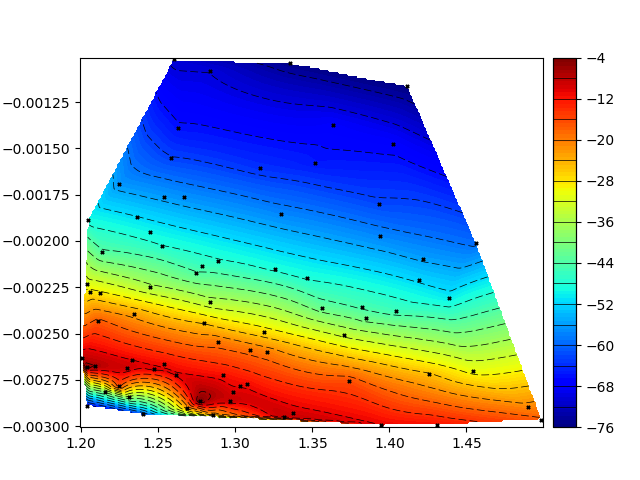

In [133]:
bin_trials(0.001, 0.00001, new_tried)

<IPython.core.display.Javascript object>


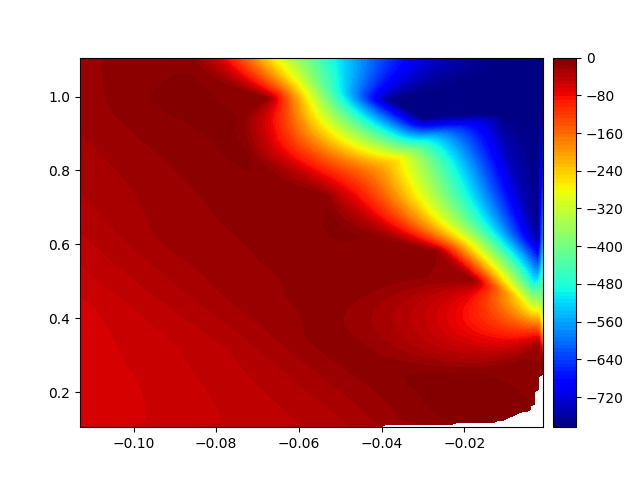

In [121]:
bin_trials(0.001, 0.005, tried)

<IPython.core.display.Javascript object>


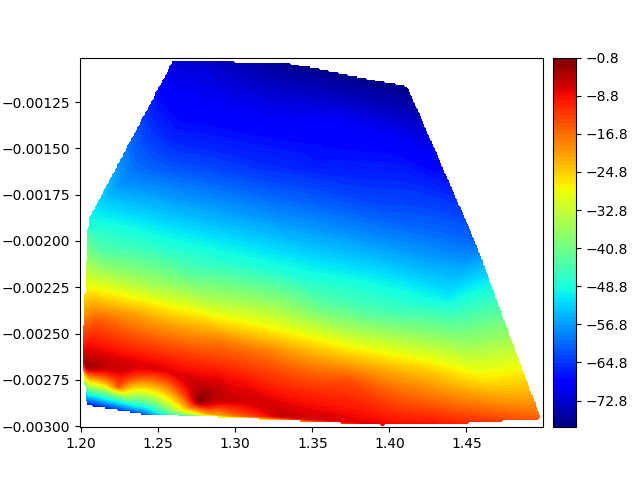

In [126]:
bin_trials(0.001, 0.00001, new_tried)

<IPython.core.display.Javascript object>


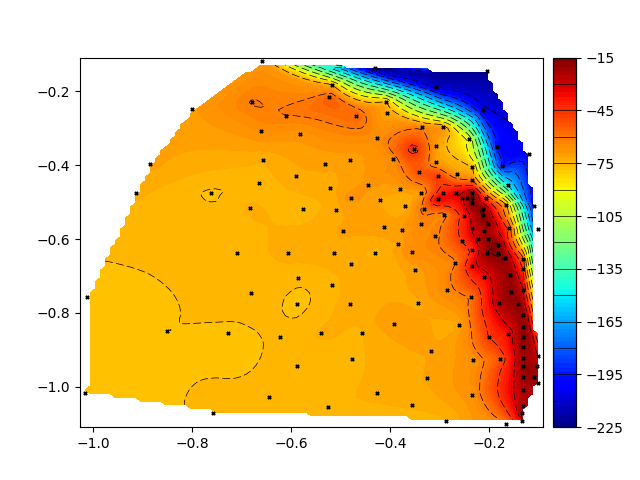

In [112]:
bin_trials(0.01, 0.01, data.trials)

In [137]:
tried = sorted([x for x in tried if not np.isinf(x[0])], key=lambda x: x[0])
tried[:50]

[(115.51511691079531,
  (2.520343102514744, 99.1234540939331),
  (2.6079079136252403, 99.99998807907104),
  (-0.09848178824416266, 0.10271341287139128, -0.2493997728725833)),
 (118.30784286706765,
  (2.653534896671772, 99.24623966217041),
  (2.4325260892510414, 99.99998807907104),
  (-0.09743828215520212, 0.16463693081483785, -0.31540207115383867)),
 (121.08460805522864,
  (2.7207842096686363, 99.29634928703308),
  (2.606680244207382, 99.99998807907104),
  (-0.0998048850285656, 0.20629753920633367, -0.2874026593305841)),
 (121.58551422459173,
  (2.560114488005638, 99.16958212852478),
  (2.1950533613562584, 99.99998807907104),
  (-0.09945202514881966, 0.1530786086500896, -0.3628888603509054)),
 (122.19782045309057,
  (2.6952624320983887, 99.2656946182251),
  (2.2846681997179985, 99.99998807907104),
  (-0.09251199099189, 0.14415218760810578, -0.3651481447260706)),
 (122.88051656094223,
  (2.7372734621167183, 99.29201006889343),
  (2.681322395801544, 99.99998807907104),
  (-0.091299891669

<IPython.core.display.Javascript object>


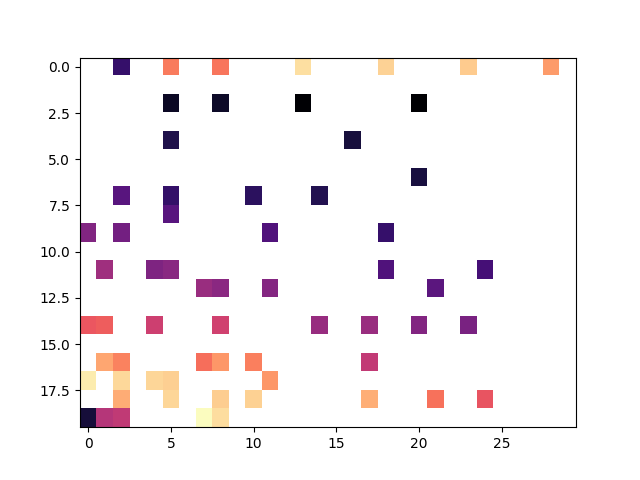

1.2002888224563926 1.4985423729771947
-0.002995171251658714 -0.0010202609406233833
(20, 30)


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [99]:
def bin_trials(x_width, y_width, data):
    X = [_[2][0] for _ in data]
    Y = [_[2][1] for _ in data]
    Z = [_[0] for _ in data]
    
    x_min, x_max = min(X), max(X)
    y_min, y_max = min(Y), max(Y)
    
    print(x_min, x_max)
    print(y_min, y_max)

    plane = np.zeros((int((y_max-y_min)//y_width)+1, int((x_max-x_min)//x_width)+1), dtype=float)
    num_trials = np.zeros(plane.shape)
    print(plane.shape)
    
    for i in range(len(X)):
        x_bin = x_width * ((X[i]-x_min) // x_width)
        y_bin = y_width * ((Y[i]-y_min) // y_width)
        _i = int(y_bin // y_width)
        _j = int(x_bin // x_width)
        plane[-_i, _j] += -np.sqrt(Z[i])
        num_trials[-_i, _j] += 1

    plane = plane / num_trials
    return plane

import matplotlib
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='red')
fig, ax = plt.subplots()
ax.imshow(bin_trials(0.01, 0.0001, new_tried), aspect='auto', cmap=plt.get_cmap('magma'))
# extent=(0, bound_x, 0, bound_y), cmap=plt.get_cmap('magma')